In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import shap

In [48]:
df = pd.read_csv("data/sequence_with_lag_features_cancel_out_total_amount.csv")
df["is_holiday"] = df["is_holiday"].replace({False: 0, True: 1})
df["1y_holiday_diff"] = df["1y_holiday_diff"].fillna(0)
df.drop(
    columns=[
        "lag_1_spending",
        "lag_2_spending",
        "lag_3_spending",
        "lag_5_spending",
        "lag_6_spending",
        "lag_7_spending",
        "lag_9_spending",
        "lag_11_spending",
        "lag_12_spending",
        "weekend_spend_ratio",
        "correlation_with_trend",
        "risk_of_default_score",
        "risk_level",
        "user_latitude",
        "user_longitude",
        "Cluster",
        "mean_amount",
        "txn_count_prev",
        "total_expense_prev",
    ],
    inplace=True,
)

df.rename(columns={"total_expense": "total_amount"}, inplace=True)
df.head(10)

num_cols = [
    "user_yearly_income",
    "user_per_capita_income",
    "user_total_debt",
    "card_num_cards_issued",
    "year_to_retirement",
    "debt_to_yearly_income_ratio",
    "income_per_card",
    "income_utilization_ratio",
    "credit_utilization_ratio",
    "oldest_card_age_years",
    "percentage_prev_monthly_expense_as_yearly",
    "percentage_prev_monthly_expense_as_capita",
    "1y_holiday_diff",
    "total_amount",
    "user_credit_score",
    "user_current_age",
]

feature_cols = num_cols + [
    "user_gender",
    "user_birth_month",
    "multi_card_user",
    "is_holiday",
]

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [49]:
# Load fresh data
print(f"Loaded data: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Original total_amount: mean=${df['total_amount'].mean():,.2f}, std=${df['total_amount'].std():,.2f}")

Loaded data: 69,814 rows, 22 columns
Original total_amount: mean=$3,901.44, std=$2,519.60


In [50]:
# Convert categorical variables
df["user_gender"] = df["user_gender"].map({"M": 1, "F": 0})

# Replace infinity values with NaN, then fill with 0
df = df.replace([np.inf, -np.inf], np.nan)

# Handle missing values
df = df.fillna(0)

In [51]:
# Inspect data for problematic values
print("Data shape:", df.shape)
print("\nChecking for inf values:")
print(df.isin([np.inf, -np.inf]).sum())
print("\nChecking for NaN values:")
print(df.isna().sum())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Data shape: (69814, 22)

Checking for inf values:
user_id                                      0
year_month                                   0
total_amount                                 0
user_gender                                  0
user_current_age                             0
user_yearly_income                           0
user_per_capita_income                       0
user_credit_score                            0
user_total_debt                              0
user_birth_month                             0
card_num_cards_issued                        0
year_to_retirement                           0
debt_to_yearly_income_ratio                  0
income_per_card                              0
multi_card_user                              0
income_utilization_ratio                     0
credit_utilization_ratio                     0
oldest_card_age_years                        0
percentage_prev_monthly_expense_as_yearly    0
percentage_prev_monthly_expense_as_capita    0
1y_holiday

In [52]:
df["year_month"] = pd.to_datetime(df["year_month"])

"""
Dataset split strategy:
- For training: use only 2014-2017 data
- For validation: use data up to 2018 (so users have 2014-2018 history to predict in 2018)
- For testing: use all data up to 2019 (so users have 2014-2019 history to predict in 2019)
"""

train_start = pd.Timestamp("2014-01-01")
train_end = pd.Timestamp("2017-12-31")
val_target_start = pd.Timestamp("2018-01-01")
val_end = pd.Timestamp("2018-12-31")
test_target_start = pd.Timestamp("2019-01-01")
test_end = pd.Timestamp("2019-09-30")

# For training: only use 2014-2017
train_df = df[(df["year_month"] >= train_start) & (df["year_month"] <= train_end)].copy()

# For validation: use 2018 data only (after training period)
val_df = df[(df["year_month"] > train_end) & (df["year_month"] <= val_end)].copy()

# For testing: use 2019 data only (after validation period)
test_df = df[(df["year_month"] > val_end) & (df["year_month"] <= test_end)].copy()

print(f"Data shapes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
print(f"Train period: {train_df['year_month'].min()} to {train_df['year_month'].max()}")
print(f"Val period: {val_df['year_month'].min()} to {val_df['year_month'].max()}")
print(f"Test period: {test_df['year_month'].min()} to {test_df['year_month'].max()}")

Data shapes: train=43305, val=14454, test=10852
Train period: 2015-01-01 00:00:00 to 2017-12-01 00:00:00
Val period: 2018-01-01 00:00:00 to 2018-12-01 00:00:00
Test period: 2019-01-01 00:00:00 to 2019-09-01 00:00:00


In [53]:
# Scale features and target together, then save target scaler params separately
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
val_df[num_cols] = scaler.transform(val_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Store target scaler parameters for inverse transform
target_idx = num_cols.index("total_amount")
target_mean = scaler.mean_[target_idx]
target_std = scaler.scale_[target_idx]
print(f"Scaling complete. Target (total_amount) stats: mean=${target_mean:,.2f}, std=${target_std:,.2f}")

Scaling complete. Target (total_amount) stats: mean=$3,907.59, std=$2,526.66


In [54]:
class TransactionDataset(Dataset):
    def __init__(
        self,
        df,
        seq_len=12,
        target_col="total_amount",
        feature_cols=None,
        store_metadata=False,
        target_start=None,
        target_end=None,
    ):
        self.df = df.sort_values(["user_id", "year_month"]).reset_index(drop=True)
        self.seq_len = seq_len
        self.target_col = target_col
        self.store_metadata = store_metadata
        self.feature_cols = feature_cols

        # Get valid indices (sequences with seq_len history)
        self.indices = []
        self.metadata = [] if store_metadata else None

        for user_id in df["user_id"].unique():
            user_df = df[df["user_id"] == user_id].reset_index(drop=True)
            for i in range(self.seq_len, len(user_df)):
                target_date = user_df.iloc[i]["year_month"]

                # Filter by target date range if specified
                if target_start is not None and target_date < target_start:
                    continue
                if target_end is not None and target_date > target_end:
                    continue

                self.indices.append((user_id, i))
                if store_metadata:
                    self.metadata.append({"user_id": user_id, "year_month": target_date})

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_id, end_idx = self.indices[idx]
        user_df = self.df[self.df["user_id"] == user_id].reset_index(drop=True)

        # Get sequence and target
        seq = user_df.iloc[end_idx - self.seq_len : end_idx][self.feature_cols].values
        target = user_df.iloc[end_idx][self.target_col]

        return torch.FloatTensor(seq), torch.FloatTensor([target])

In [55]:
class TransformerAmountPredictor(nn.Module):
    def __init__(self, num_features, hidden_dim=128, num_layers=2, nhead=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(num_features, hidden_dim)
        # Learnable positional encoding, assuming max sequence length of 50 (window_size is 12)
        self.pos_embedding = nn.Parameter(torch.randn(1, 50, hidden_dim) * 0.01)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim * 4, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, num_features]
        B, L, _ = x.shape
        x = self.input_proj(x) + self.pos_embedding[:, :L, :]
        out = self.transformer_encoder(x)
        last_out = out[:, -1, :]  # [batch, hidden_dim]
        y_pred = self.fc(last_out)  # [batch, 1]
        return y_pred.squeeze(-1)

In [56]:
# Hyperparameters - Adjusted to reduce overfitting
SEQ_LEN = 12  # 12 months of history to predict next month
BATCH_SIZE = 128  # Increased batch size for better generalization
HIDDEN_DIM = 64  # Reduced from 128 to decrease model capacity
NUM_LAYERS = 2
NHEAD = 4
DROPOUT = 0.4  # Increased from 0.2 for stronger regularization
LEARNING_RATE = 0.0005  # Transformer learning rate
WEIGHT_DECAY = 1e-4  # L2 regularization
EPOCHS = 200
PATIENCE = 10

# Choose active model: 'transformer' or 'lstm'
ACTIVE_MODEL = "transformer"
print(f"Active model: {ACTIVE_MODEL}")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get number of features
NUM_FEATURES = len(feature_cols)
print(f"Number of features: {NUM_FEATURES}")

# Initialize transformer model
transformer_model = TransformerAmountPredictor(
    num_features=NUM_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, nhead=NHEAD, dropout=DROPOUT
).to(device)


# Models dict
models = {
    "transformer": transformer_model,
}

# Optimizers per model
optimizers = {
    "transformer": torch.optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
}

# Schedulers per model
schedulers = {
    "transformer": torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizers["transformer"], mode="min", factor=0.5, patience=3
    ),
}

# Epoch / patience selection based on active model
MODEL_EPOCHS = EPOCHS if ACTIVE_MODEL == "transformer" else EPOCHS
MODEL_PATIENCE = PATIENCE if ACTIVE_MODEL == "transformer" else PATIENCE

criterion = nn.MSELoss()

print(f"Configured {ACTIVE_MODEL} with epochs={MODEL_EPOCHS}, patience={MODEL_PATIENCE}")

Active model: transformer
Using device: cuda
Number of features: 20
Configured transformer with epochs=200, patience=10


In [57]:
# Create datasets with metadata storage and target date filtering
# Train: predict for any month with 12-month history (2015-01 onwards in 2014-2017 data)
train_dataset = TransactionDataset(
    train_df, seq_len=SEQ_LEN, target_col="total_amount", feature_cols=feature_cols, store_metadata=True
)

# Val: For 2018 predictions, we need 12 months of history (from 2017)
# So we use train+val data, but only create predictions for 2018
val_full_df = pd.concat([train_df, val_df], ignore_index=True)
val_dataset = TransactionDataset(
    val_full_df,
    seq_len=SEQ_LEN,
    target_col="total_amount",
    feature_cols=feature_cols,
    store_metadata=True,
    target_start=pd.Timestamp("2018-01-01"),
    target_end=pd.Timestamp("2018-12-31"),
)

# Test: For 2019 predictions, we need 12 months of history (from 2018)
# So we use train+val+test data, but only create predictions for 2019
test_full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
test_dataset = TransactionDataset(
    test_full_df,
    seq_len=SEQ_LEN,
    target_col="total_amount",
    feature_cols=feature_cols,
    store_metadata=True,
    target_start=pd.Timestamp("2019-01-01"),
    target_end=pd.Timestamp("2019-09-30"),
)

NUM_WORKERS = 12
PIN_MEMORY = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print(f"DataLoader configuration: num_workers={NUM_WORKERS}, pin_memory={PIN_MEMORY}")
print(f"Persistent workers: train=True, val/test=False")

DataLoader configuration: num_workers=12, pin_memory=True
Persistent workers: train=True, val/test=False


No existing best_transformer.pt found. Starting fresh training.


Epoch 1/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 97.22it/s] 



Epoch 01 (transformer) | Train: 0.252598 | Val: 0.147113 | Test: 0.143319
Saved new best model best_transformer.pt (val_loss=0.147113)


Epoch 2/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 97.56it/s] 



Epoch 02 (transformer) | Train: 0.157478 | Val: 0.124088 | Test: 0.120289
Saved new best model best_transformer.pt (val_loss=0.124088)


Epoch 3/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 96.20it/s] 



Epoch 03 (transformer) | Train: 0.144560 | Val: 0.134260 | Test: 0.131025
 No improvement (1/10)


Epoch 4/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 96.20it/s] 



Epoch 04 (transformer) | Train: 0.139432 | Val: 0.120267 | Test: 0.116996
Saved new best model best_transformer.pt (val_loss=0.120267)


Epoch 5/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 93.90it/s] 



Epoch 05 (transformer) | Train: 0.135571 | Val: 0.122717 | Test: 0.120741
 No improvement (1/10)


Epoch 6/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 97.96it/s] 



Epoch 06 (transformer) | Train: 0.134130 | Val: 0.119223 | Test: 0.116699
Saved new best model best_transformer.pt (val_loss=0.119223)


Epoch 7/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 95.13it/s] 



Epoch 07 (transformer) | Train: 0.132807 | Val: 0.129758 | Test: 0.126889
 No improvement (1/10)


Epoch 8/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 93.75it/s] 



Epoch 08 (transformer) | Train: 0.130397 | Val: 0.119576 | Test: 0.117725
 No improvement (2/10)


Epoch 9/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 97.50it/s] 



Epoch 09 (transformer) | Train: 0.125623 | Val: 0.121272 | Test: 0.117760
 No improvement (3/10)


Epoch 10/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 87.20it/s] 



Epoch 10 (transformer) | Train: 0.128400 | Val: 0.135051 | Test: 0.133462
 No improvement (4/10)


Epoch 11/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 96.86it/s] 



Epoch 11 (transformer) | Train: 0.122807 | Val: 0.118928 | Test: 0.117442
Saved new best model best_transformer.pt (val_loss=0.118928)


Epoch 12/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 93.78it/s] 



Epoch 12 (transformer) | Train: 0.122144 | Val: 0.119978 | Test: 0.118371
 No improvement (1/10)


Epoch 13/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 97.38it/s] 



Epoch 13 (transformer) | Train: 0.120637 | Val: 0.116741 | Test: 0.114358
Saved new best model best_transformer.pt (val_loss=0.116741)


Epoch 14/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 86.64it/s] 



Epoch 14 (transformer) | Train: 0.120833 | Val: 0.120320 | Test: 0.118701
 No improvement (1/10)


Epoch 15/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 90.95it/s] 



Epoch 15 (transformer) | Train: 0.122073 | Val: 0.117674 | Test: 0.116799
 No improvement (2/10)


Epoch 16/200 [Test]: 100%|██████████| 85/85 [00:02<00:00, 41.23it/s]



Epoch 16 (transformer) | Train: 0.121186 | Val: 0.126798 | Test: 0.125543
 No improvement (3/10)


Epoch 17/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 74.47it/s] 



Epoch 17 (transformer) | Train: 0.121260 | Val: 0.116110 | Test: 0.114086
Saved new best model best_transformer.pt (val_loss=0.116110)


Epoch 18/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 77.34it/s] 



Epoch 18 (transformer) | Train: 0.121049 | Val: 0.126839 | Test: 0.124435
 No improvement (1/10)


Epoch 19/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 80.00it/s] 



Epoch 19 (transformer) | Train: 0.119685 | Val: 0.127209 | Test: 0.126030
 No improvement (2/10)


Epoch 20/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 89.92it/s] 



Epoch 20 (transformer) | Train: 0.120113 | Val: 0.114509 | Test: 0.112521
Saved new best model best_transformer.pt (val_loss=0.114509)


Epoch 21/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 74.36it/s] 



Epoch 21 (transformer) | Train: 0.121114 | Val: 0.118219 | Test: 0.116514
 No improvement (1/10)


Epoch 22/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 88.62it/s] 



Epoch 22 (transformer) | Train: 0.118771 | Val: 0.121330 | Test: 0.120760
 No improvement (2/10)


Epoch 23/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 66.36it/s]



Epoch 23 (transformer) | Train: 0.117920 | Val: 0.127887 | Test: 0.126725
 No improvement (3/10)


Epoch 24/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 63.68it/s] 



Epoch 24 (transformer) | Train: 0.118000 | Val: 0.123532 | Test: 0.122200
 No improvement (4/10)


Epoch 25/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 85.19it/s] 



Epoch 25 (transformer) | Train: 0.117996 | Val: 0.114328 | Test: 0.112601
Saved new best model best_transformer.pt (val_loss=0.114328)


Epoch 26/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 78.22it/s] 



Epoch 26 (transformer) | Train: 0.115594 | Val: 0.121948 | Test: 0.120314
 No improvement (1/10)


Epoch 27/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 86.69it/s] 



Epoch 27 (transformer) | Train: 0.116124 | Val: 0.120493 | Test: 0.118728
 No improvement (2/10)


Epoch 28/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 84.44it/s] 



Epoch 28 (transformer) | Train: 0.115393 | Val: 0.124414 | Test: 0.122010
 No improvement (3/10)


Epoch 29/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 86.72it/s] 



Epoch 29 (transformer) | Train: 0.115591 | Val: 0.114185 | Test: 0.112390
Saved new best model best_transformer.pt (val_loss=0.114185)


Epoch 30/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 78.74it/s] 



Epoch 30 (transformer) | Train: 0.115992 | Val: 0.119749 | Test: 0.118613
 No improvement (1/10)


Epoch 31/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 87.25it/s] 



Epoch 31 (transformer) | Train: 0.115353 | Val: 0.118620 | Test: 0.117376
 No improvement (2/10)


Epoch 32/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 88.60it/s] 



Epoch 32 (transformer) | Train: 0.115901 | Val: 0.118440 | Test: 0.117624
 No improvement (3/10)


Epoch 33/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 81.23it/s] 



Epoch 33 (transformer) | Train: 0.115080 | Val: 0.114316 | Test: 0.112785
 No improvement (4/10)


Epoch 34/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 82.10it/s] 



Epoch 34 (transformer) | Train: 0.113798 | Val: 0.114983 | Test: 0.112836
 No improvement (5/10)


Epoch 35/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 86.76it/s] 



Epoch 35 (transformer) | Train: 0.114539 | Val: 0.116097 | Test: 0.114562
 No improvement (6/10)


Epoch 36/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 84.50it/s] 



Epoch 36 (transformer) | Train: 0.114218 | Val: 0.115690 | Test: 0.114449
 No improvement (7/10)


Epoch 37/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 83.50it/s] 



Epoch 37 (transformer) | Train: 0.114015 | Val: 0.113528 | Test: 0.111905
Saved new best model best_transformer.pt (val_loss=0.113528)


Epoch 38/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 84.31it/s] 



Epoch 38 (transformer) | Train: 0.113456 | Val: 0.113998 | Test: 0.112537
 No improvement (1/10)


Epoch 39/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 84.56it/s] 



Epoch 39 (transformer) | Train: 0.113664 | Val: 0.114790 | Test: 0.113861
 No improvement (2/10)


Epoch 40/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 81.11it/s]



Epoch 40 (transformer) | Train: 0.113417 | Val: 0.115904 | Test: 0.114645
 No improvement (3/10)


Epoch 41/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 77.48it/s] 



Epoch 41 (transformer) | Train: 0.113579 | Val: 0.117073 | Test: 0.115566
 No improvement (4/10)


Epoch 42/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 90.66it/s] 



Epoch 42 (transformer) | Train: 0.113316 | Val: 0.115080 | Test: 0.113617
 No improvement (5/10)


Epoch 43/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 83.75it/s] 



Epoch 43 (transformer) | Train: 0.113563 | Val: 0.115511 | Test: 0.114142
 No improvement (6/10)


Epoch 44/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 88.76it/s] 



Epoch 44 (transformer) | Train: 0.112994 | Val: 0.113676 | Test: 0.111937
 No improvement (7/10)


Epoch 45/200 [Test]: 100%|██████████| 85/85 [00:01<00:00, 81.13it/s] 



Epoch 45 (transformer) | Train: 0.112461 | Val: 0.114715 | Test: 0.113481
 No improvement (8/10)


Epoch 46/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 87.87it/s] 



Epoch 46 (transformer) | Train: 0.111841 | Val: 0.115025 | Test: 0.113587
 No improvement (9/10)


Epoch 47/200 [Test]: 100%|██████████| 85/85 [00:00<00:00, 88.66it/s] 



Epoch 47 (transformer) | Train: 0.112910 | Val: 0.115441 | Test: 0.114136
 No improvement (10/10)
Early stopping triggered


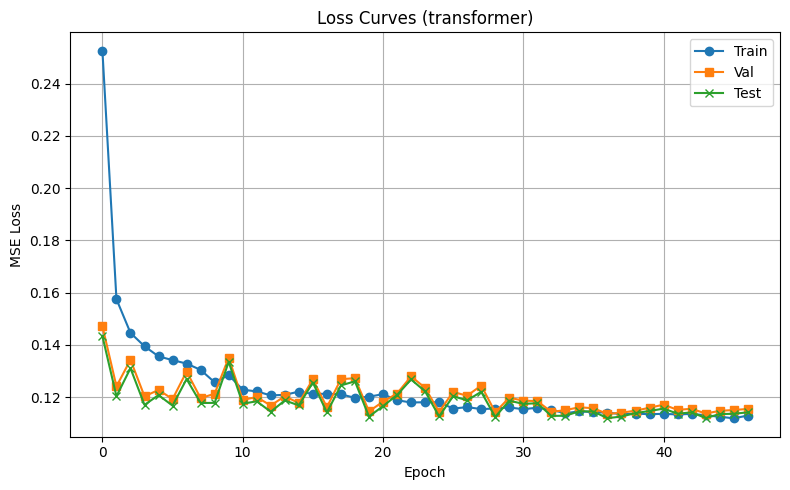

In [58]:
active_model = models[ACTIVE_MODEL]
optimizer = optimizers[ACTIVE_MODEL]
scheduler = schedulers[ACTIVE_MODEL]

best_val_loss = float("inf")
patience_counter = 0
MODEL_FILENAME = f"best_{ACTIVE_MODEL}.pt"

if os.path.isfile(MODEL_FILENAME):
    state_dict = torch.load(MODEL_FILENAME, map_location=device, weights_only=True)
    active_model.load_state_dict(state_dict)
    print(f"Loaded existing {MODEL_FILENAME} (weights only). Continuing training from epoch 0.")
else:
    print(f"No existing {MODEL_FILENAME} found. Starting fresh training.")

train_history = {"train_loss": [], "val_loss": [], "test_loss": []}

for epoch in range(MODEL_EPOCHS):
    active_model.train()
    train_losses = []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MODEL_EPOCHS} [Train-{ACTIVE_MODEL}]"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = active_model(X)
        loss = criterion(preds, y.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # Validation
    active_model.eval()
    val_losses = []
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{MODEL_EPOCHS} [Val]"):
            X, y = X.to(device), y.to(device)
            preds = active_model(X)
            loss = criterion(preds, y.squeeze())
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)

    # Test (monitor only)
    test_losses = []
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{MODEL_EPOCHS} [Test]"):
            X, y = X.to(device), y.to(device)
            preds = active_model(X)
            loss = criterion(preds, y.squeeze())
            test_losses.append(loss.item())
    avg_test_loss = np.mean(test_losses)

    train_history["train_loss"].append(avg_train_loss)
    train_history["val_loss"].append(avg_val_loss)
    train_history["test_loss"].append(avg_test_loss)

    # Scheduler step
    scheduler.step(avg_val_loss)

    print(
        f"\nEpoch {epoch+1:02d} ({ACTIVE_MODEL}) | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | Test: {avg_test_loss:.6f}"
    )

    # Early stopping + best model save
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(active_model.state_dict(), MODEL_FILENAME)
        print(f"Saved new best model {MODEL_FILENAME} (val_loss={best_val_loss:.6f})")
    else:
        patience_counter += 1
        print(f" No improvement ({patience_counter}/{MODEL_PATIENCE})")
        if patience_counter >= MODEL_PATIENCE:
            print("Early stopping triggered")
            break

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train", marker="o")
plt.plot(train_history["val_loss"], label="Val", marker="s")
plt.plot(train_history["test_loss"], label="Test", marker="x")
plt.title(f"Loss Curves ({ACTIVE_MODEL})")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
def evaluate_model(loader, model, device, scaler, target_col_idx):
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()  # Flatten to ensure 1D
    target_mean = scaler.mean_[target_col_idx]
    target_scale = scaler.scale_[target_col_idx]
    y_true_orig = (y_true * target_scale) + target_mean
    y_pred_orig = (y_pred * target_scale) + target_mean
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / (y_true_orig + 1e-8))) * 100
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


# Load best weights for active model
MODEL_FILENAME = f"best_{ACTIVE_MODEL}.pt"
active_model = models[ACTIVE_MODEL]
if os.path.isfile(MODEL_FILENAME):
    state_dict = torch.load(MODEL_FILENAME, map_location=device, weights_only=True)
    active_model.load_state_dict(state_dict)
    print(f"Loaded {MODEL_FILENAME} for evaluation")
else:
    print(f"{MODEL_FILENAME} not found; evaluating current {ACTIVE_MODEL} state")

active_model.to(device)
active_model.eval()

target_idx = num_cols.index("total_amount")
val_metrics = evaluate_model(val_loader, active_model, device, scaler, target_idx)
print(f"\nValidation Metrics ({ACTIVE_MODEL}, original scale):")
for k, v in val_metrics.items():
    print(f"  {k}: {v:.6f}")

test_metrics = evaluate_model(test_loader, active_model, device, scaler, target_idx)
print(f"\nTest Metrics ({ACTIVE_MODEL}, original scale):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.6f}")

Loaded best_transformer.pt for evaluation

Validation Metrics (transformer, original scale):
  MAE: 606.685486
  MSE: 721499.250000
  RMSE: 849.411120
  MAPE: 18.324044

Validation Metrics (transformer, original scale):
  MAE: 606.685486
  MSE: 721499.250000
  RMSE: 849.411120
  MAPE: 18.324044

Test Metrics (transformer, original scale):
  MAE: 606.020630
  MSE: 712476.375000
  RMSE: 844.083156
  MAPE: 18.496263

Test Metrics (transformer, original scale):
  MAE: 606.020630
  MSE: 712476.375000
  RMSE: 844.083156
  MAPE: 18.496263


In [60]:
def generate_predictions(dataset, set_name, batch_size=512):
    preds_records = []
    seq_buffer = []
    target_buffer = []
    meta_buffer = []

    def flush_buffer():
        if not seq_buffer:
            return
        X_batch = torch.stack(seq_buffer).to(device)  # [B, seq_len, features]
        with torch.no_grad():
            batch_preds = active_model(X_batch).detach().cpu().numpy()
        targets_np = torch.stack(target_buffer).cpu().numpy()
        for m, t, p in zip(meta_buffer, targets_np, batch_preds):
            actual_scaled = float(t.squeeze())
            pred_scaled = float(p.squeeze())
            actual_dollars = (actual_scaled * scaler.scale_[target_idx]) + scaler.mean_[target_idx]
            predicted_dollars = (pred_scaled * scaler.scale_[target_idx]) + scaler.mean_[target_idx]
            preds_records.append(
                {
                    "user_id": m["user_id"],
                    "date": m["year_month"],
                    "set": set_name,
                    "actual": actual_scaled,
                    "predicted": pred_scaled,
                    "actual_dollars": actual_dollars,
                    "predicted_dollars": predicted_dollars,
                }
            )
        seq_buffer.clear()
        target_buffer.clear()
        meta_buffer.clear()

    # Iterate directly over dataset indices to preserve correct ordering
    for i in range(len(dataset)):
        seq, target = dataset[i]  # already FloatTensors
        seq_buffer.append(seq)
        target_buffer.append(target)
        meta_buffer.append(dataset.metadata[i])
        if len(seq_buffer) >= batch_size:
            flush_buffer()
    flush_buffer()
    return preds_records


all_predictions = []
all_predictions.extend(generate_predictions(train_dataset, "train"))
all_predictions.extend(generate_predictions(val_dataset, "val"))
all_predictions.extend(generate_predictions(test_dataset, "test"))

plot_df = pd.DataFrame(all_predictions).sort_values(["user_id", "date", "set"]).reset_index(drop=True)

In [61]:
# Fully unified visualization without separate branches.
# Provides both aggregate (user_id=None) and per-user (user_id=...) plots via normalized prep.
# Usage:
#   plot_predictions(plot_df)                  -> aggregate mean across users
#   plot_predictions(plot_df, user_id=123)     -> detailed plots for user 123


def plot_predictions(plot_df, user_id=None, show_scaled=True):
    """Unified prediction visualization.

    When user_id is None: plots aggregate monthly mean actual vs predicted (dollars) across all users;
    optionally also a scaled mean panel if show_scaled=True.
    When user_id is provided: plots the user's actual vs predicted (scaled + dollars).

    Parameters
    ----------
    plot_df : DataFrame
        Columns required: user_id, date, set, actual, predicted, actual_dollars, predicted_dollars.
    user_id : int or None
        Target user for detailed plots; None triggers aggregate mode.
    show_scaled : bool
        Whether to include scaled-value panel. For aggregate mode, uses mean of scaled values.
    """
    # Normalize data source: either per-user rows or aggregated means.
    if user_id is None:
        # Aggregate mode: compute means for both scaled and dollar values
        agg = (
            plot_df.groupby(["date", "set"])
            .agg(
                actual_scaled_mean=("actual", "mean"),
                predicted_scaled_mean=("predicted", "mean"),
                actual_dollars_mean=("actual_dollars", "mean"),
                predicted_dollars_mean=("predicted_dollars", "mean"),
            )
            .reset_index()
        )
        if len(agg) == 0:
            print("❌ No data available for aggregate plotting")
            return
        title_prefix = "Mean Across Users"
        # Decide subplot count
        n_rows = 2 if show_scaled else 1
        fig, axes = plt.subplots(n_rows, 1, figsize=(16, 6 * n_rows))
        if n_rows == 1:
            axes = [axes]
        # Panel 1: scaled (optional)
        if show_scaled:
            ax_scaled = axes[0]
            for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
                set_df = agg[agg["set"] == set_name].sort_values("date")
                if len(set_df) == 0:
                    continue
                ax_scaled.plot(
                    set_df["date"],
                    set_df["actual_scaled_mean"],
                    "o-",
                    color=color,
                    markersize=6,
                    linewidth=2,
                    label=f"{set_name.capitalize()} Actual (Mean)",
                    alpha=0.6,
                )
                ax_scaled.plot(
                    set_df["date"],
                    set_df["predicted_scaled_mean"],
                    "s--",
                    color=color,
                    markersize=6,
                    linewidth=2,
                    label=f"{set_name.capitalize()} Predicted (Mean)",
                    alpha=0.9,
                )
            ax_scaled.set_xlabel("Date", fontsize=12)
            ax_scaled.set_ylabel("Scaled Spending (mean)", fontsize=12)
            ax_scaled.set_title(f"{title_prefix}: Scaled Actual vs Predicted", fontsize=14, fontweight="bold")
            ax_scaled.legend(loc="best", fontsize=10)
            ax_scaled.grid(True, alpha=0.3)
        # Panel 2 or 1: dollars
        ax_dollars = axes[-1]
        for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
            set_df = agg[agg["set"] == set_name].sort_values("date")
            if len(set_df) == 0:
                continue
            ax_dollars.plot(
                set_df["date"],
                set_df["actual_dollars_mean"],
                "o-",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Actual (Mean)",
                alpha=0.6,
            )
            ax_dollars.plot(
                set_df["date"],
                set_df["predicted_dollars_mean"],
                "s--",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Predicted (Mean)",
                alpha=0.9,
            )
        ax_dollars.set_xlabel("Date", fontsize=12)
        ax_dollars.set_ylabel("Mean Monthly Spending ($)", fontsize=12)
        ax_dollars.set_title(f"{title_prefix}: Dollar Actual vs Predicted", fontsize=14, fontweight="bold")
        ax_dollars.legend(loc="best", fontsize=10)
        ax_dollars.grid(True, alpha=0.3)
        ax_dollars.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
        plt.tight_layout()
        plt.show()
        return
    # Per-user mode
    user_data = plot_df[plot_df["user_id"] == user_id].sort_values("date")
    if len(user_data) == 0:
        print(f"❌ No data found for user {user_id}")
        return
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10)) if show_scaled else (plt.subplots(1, 1, figsize=(16, 6)))
    if show_scaled:
        for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
            set_df = user_data[user_data["set"] == set_name]
            if len(set_df) == 0:
                continue
            ax1.plot(
                set_df["date"],
                set_df["actual"],
                "o-",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Actual",
                alpha=0.6,
            )
            ax1.plot(
                set_df["date"],
                set_df["predicted"],
                "s--",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Predicted",
                alpha=0.9,
            )
        ax1.set_xlabel("Date", fontsize=12)
        ax1.set_ylabel("Monthly Spending (scaled)", fontsize=12)
        ax1.set_title(f"User {user_id}: Actual vs Predicted (Scaled Values)", fontsize=14, fontweight="bold")
        ax1.legend(loc="best", fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax_dollars = ax2 if show_scaled else ax1
    else:
        ax_dollars = ax1
    for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
        set_df = user_data[user_data["set"] == set_name]
        if len(set_df) == 0:
            continue
        ax_dollars.plot(
            set_df["date"],
            set_df["actual_dollars"],
            "o-",
            color=color,
            markersize=6,
            linewidth=2,
            label=f"{set_name.capitalize()} Actual",
            alpha=0.6,
        )
        ax_dollars.plot(
            set_df["date"],
            set_df["predicted_dollars"],
            "s--",
            color=color,
            markersize=6,
            linewidth=2,
            label=f"{set_name.capitalize()} Predicted",
            alpha=0.9,
        )
    ax_dollars.set_xlabel("Date", fontsize=12)
    ax_dollars.set_ylabel("Monthly Spending ($)", fontsize=12)
    ax_dollars.set_title(f"User {user_id}: Actual vs Predicted (Dollar Amounts)", fontsize=14, fontweight="bold")
    ax_dollars.legend(loc="best", fontsize=10)
    ax_dollars.grid(True, alpha=0.3)
    ax_dollars.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
    plt.tight_layout()
    plt.show()

Mean Predictions Across All Users:


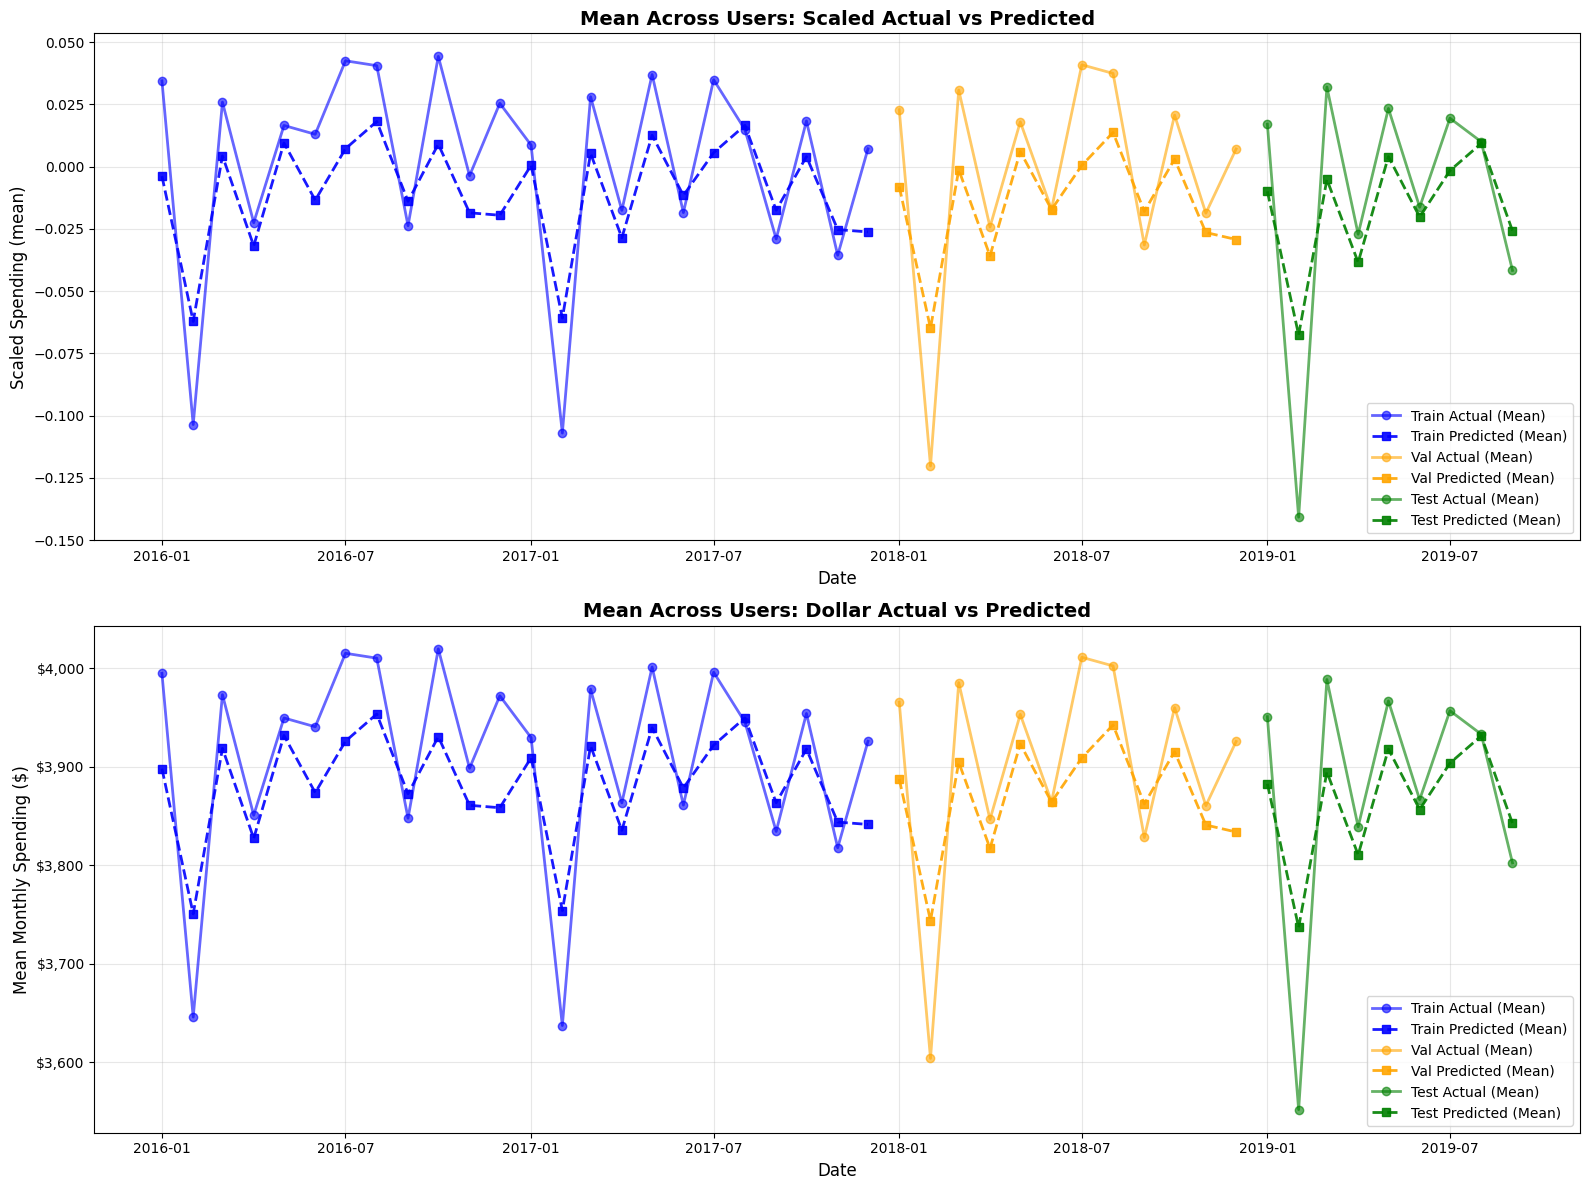


Example User Predictions:


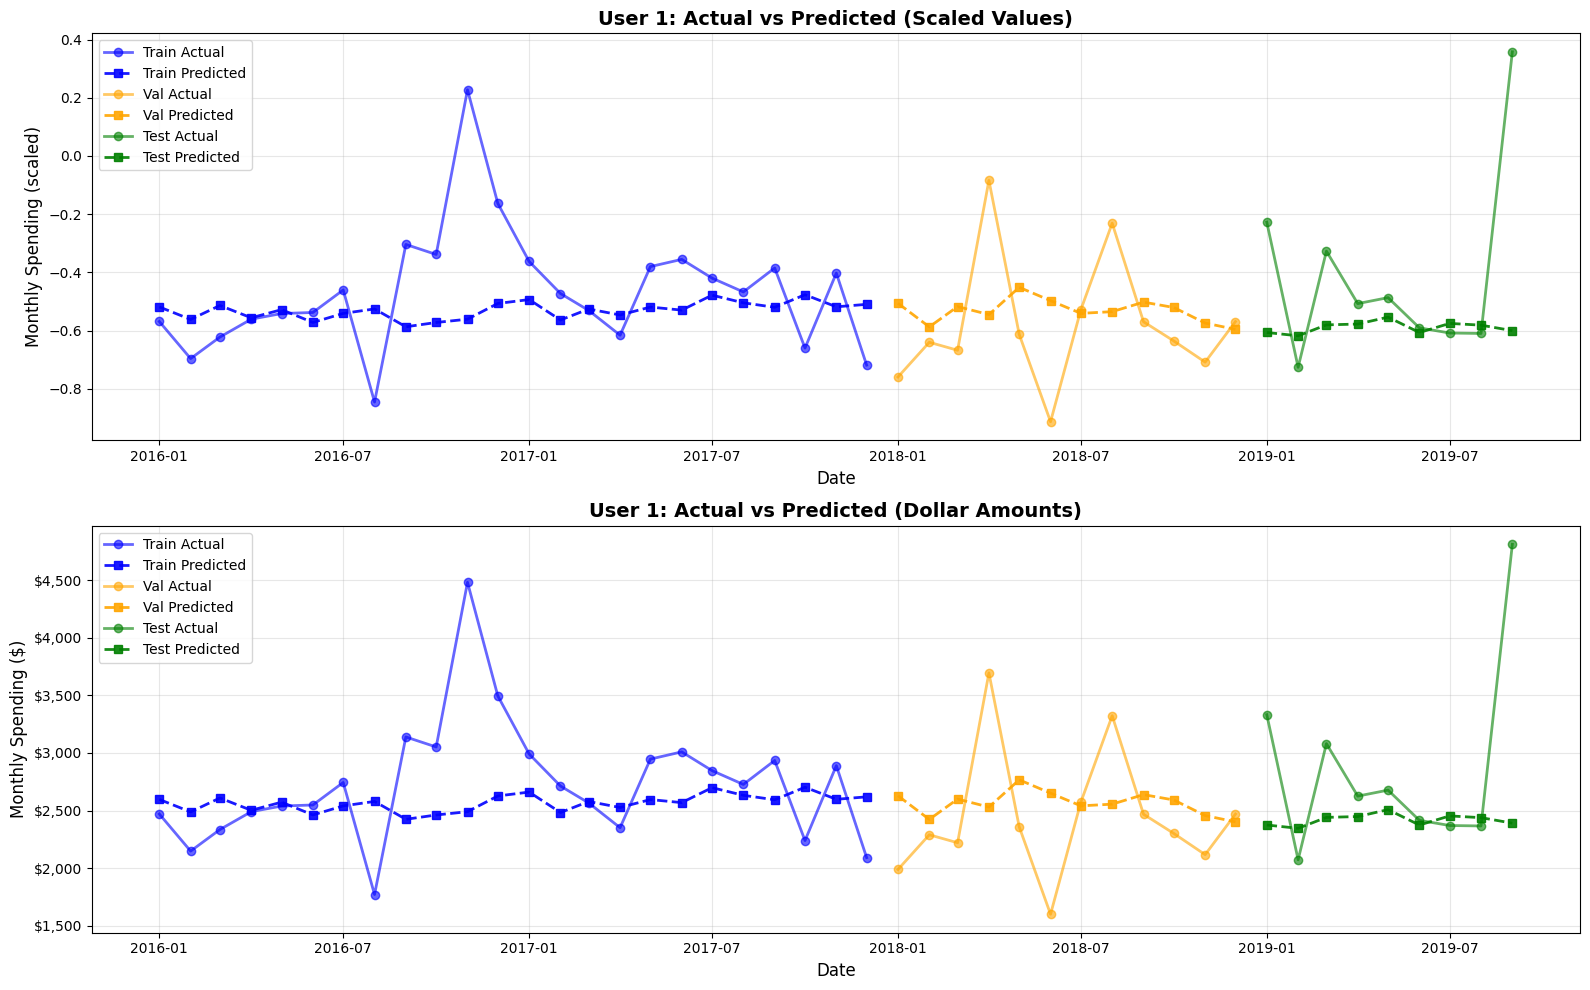

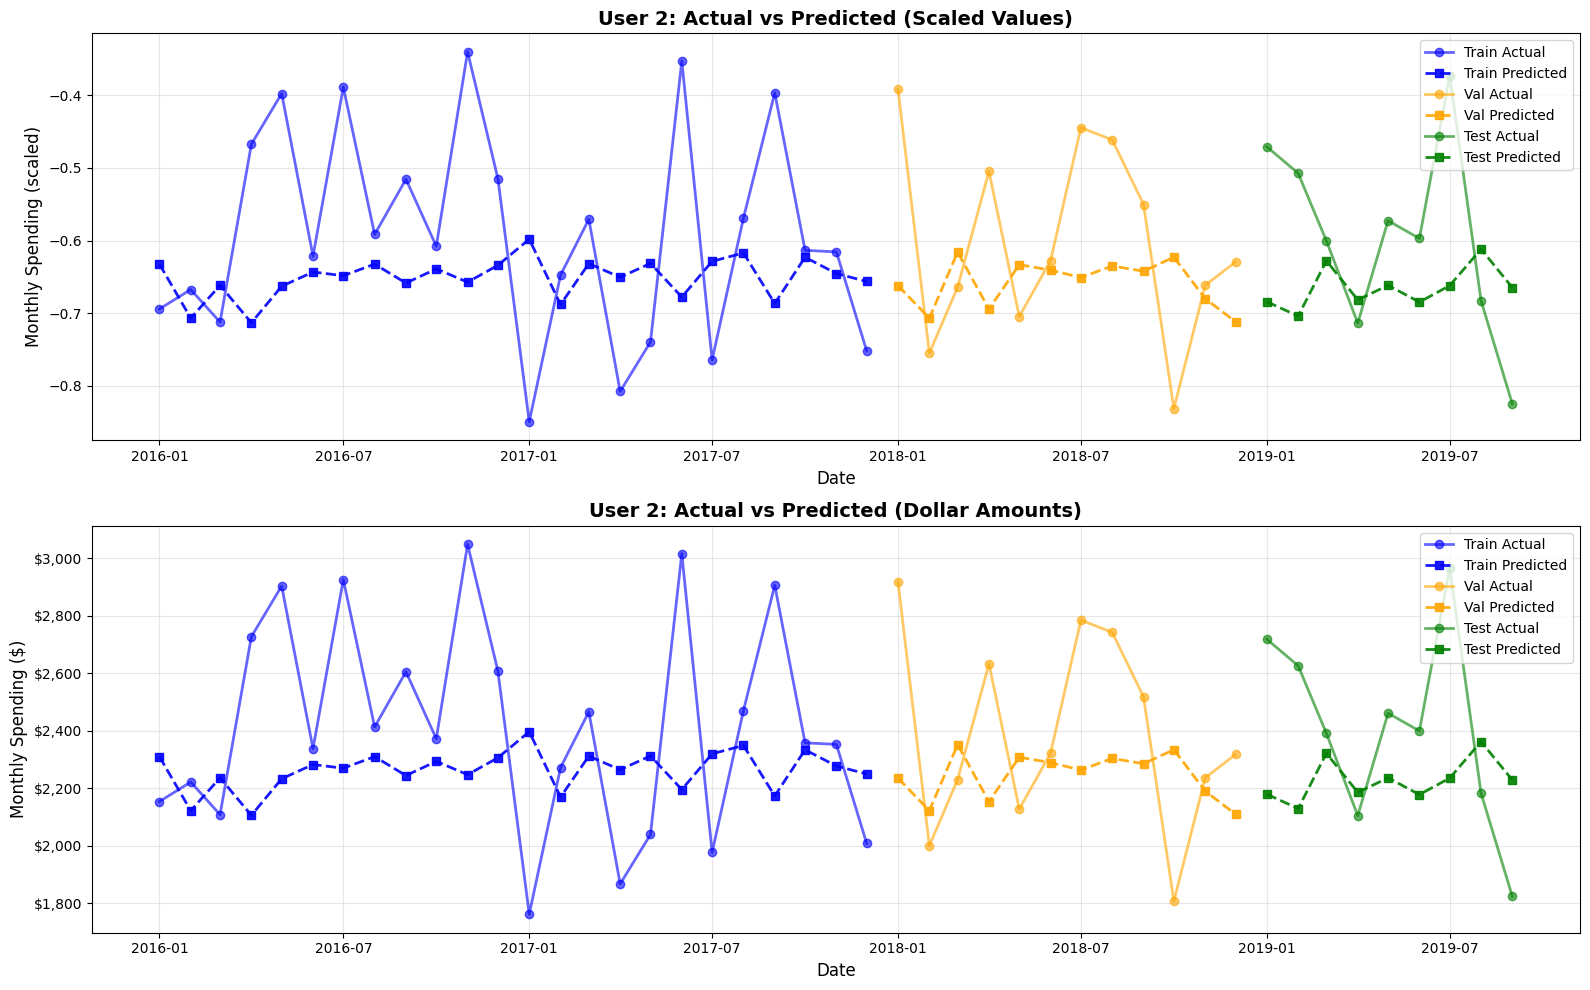

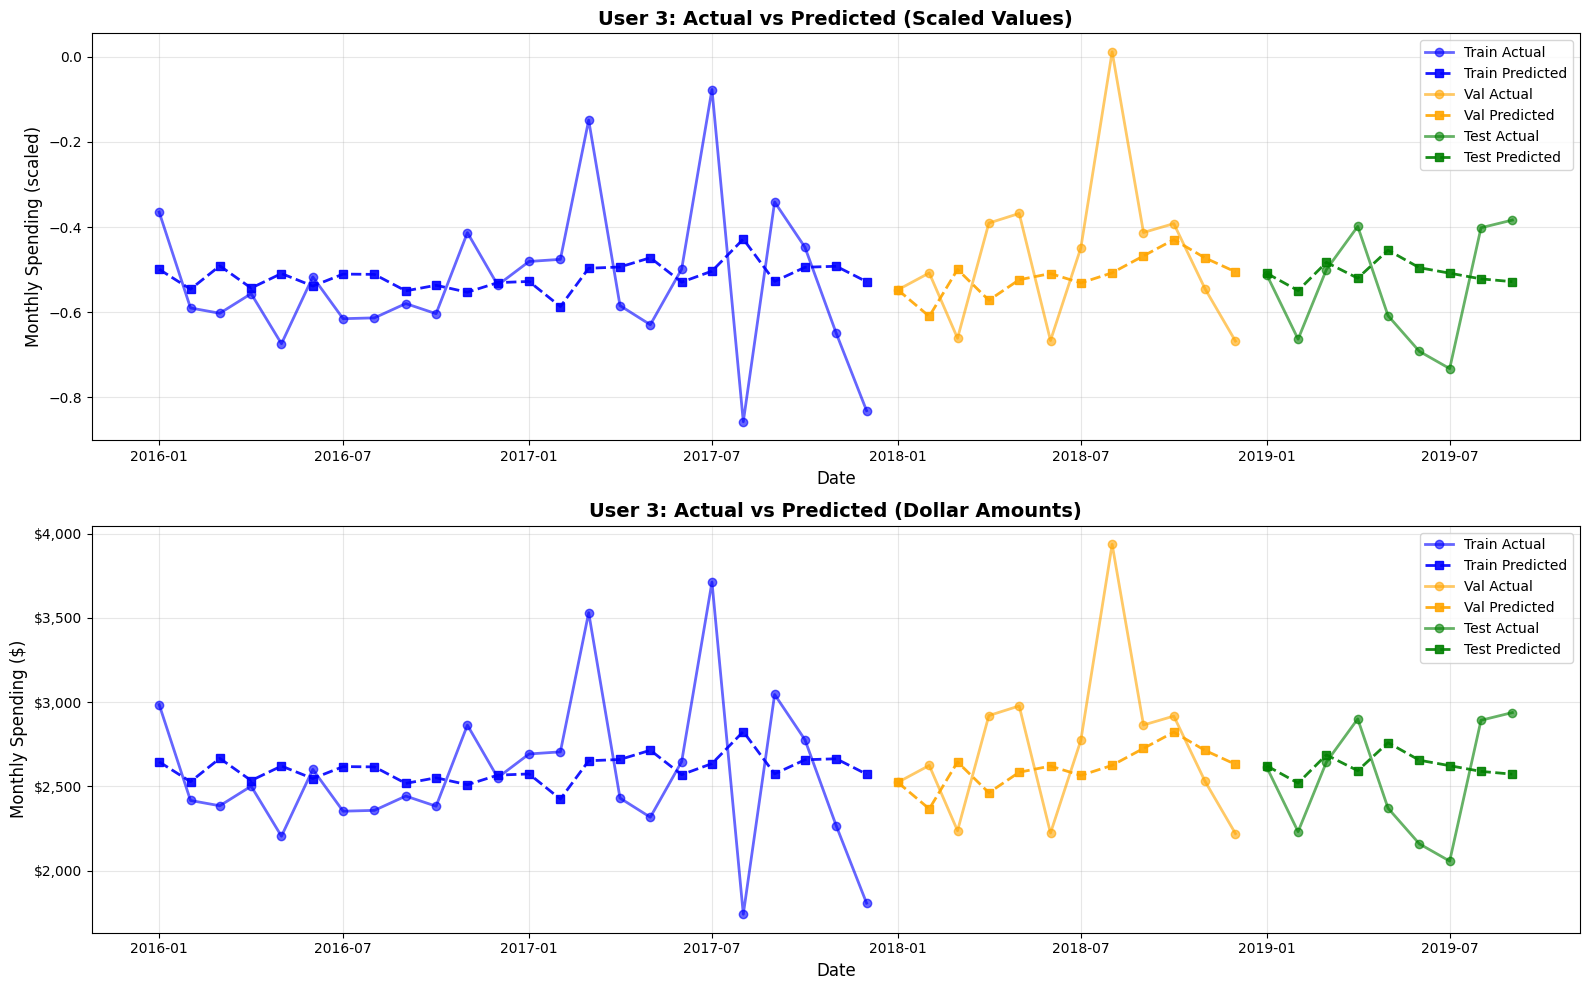

In [62]:
print("Mean Predictions Across All Users:")
print("=" * 60)
plot_predictions(plot_df)  # Aggregate mean

print("\nExample User Predictions:")
print("=" * 60)

sample_users = [1, 2, 3]
for user_id in sample_users:
    plot_predictions(plot_df, user_id=user_id)

SHAP Feature Importance Analysis

Background data shape: torch.Size([10000, 12, 20])
Features per timestep: 20
Sequence length: 12

Initializing SHAP GradientExplainer (this may take a moment)...
Explaining 100 test samples...
SHAP values shape: (100, 12, 20)


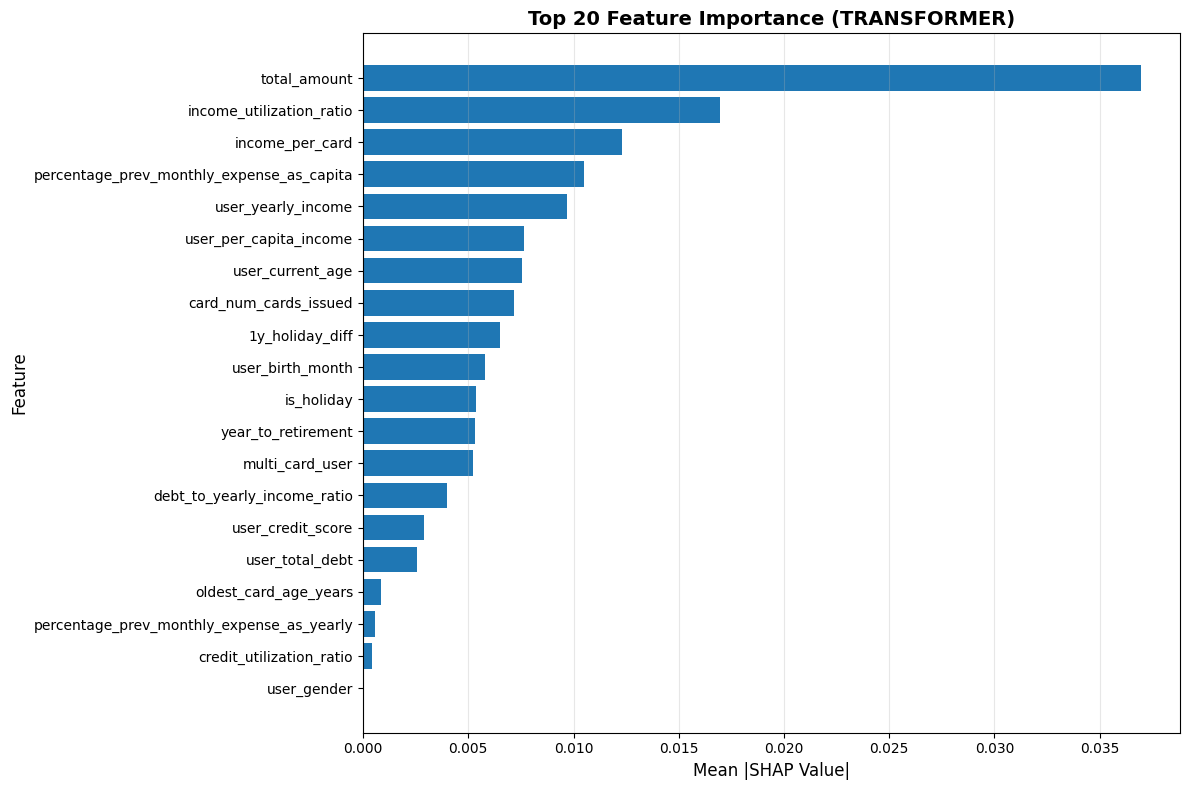


SHAP Summary Plot (Feature Impact Distribution):


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


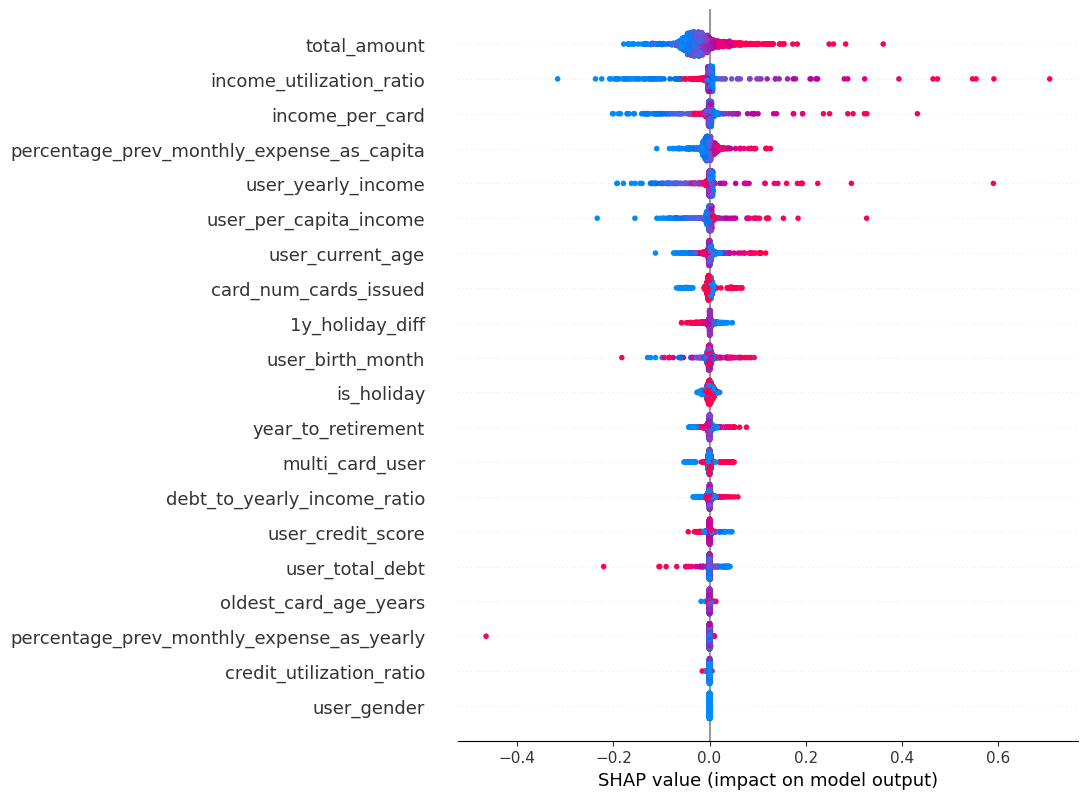

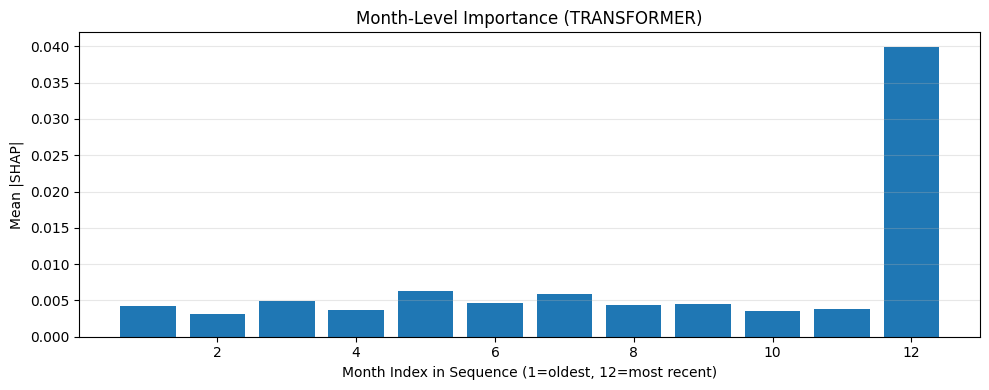

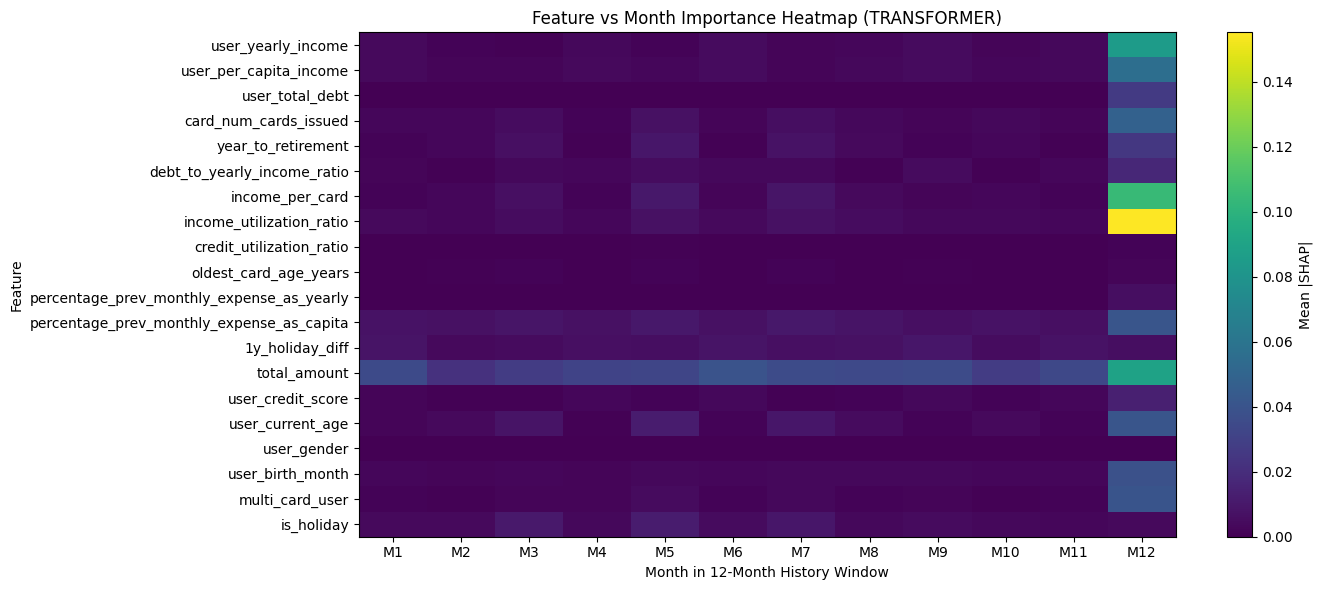


SHAP Analysis Complete!


In [63]:
# SHAP Analysis - Feature Importance
print("=" * 80)
print("SHAP Feature Importance Analysis")
print("=" * 80)


# Prepare model wrapper for SHAP
class ModelWrapper(nn.Module):
    """Wrapper to extract predictions from the model for SHAP"""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        # Ensure output is 2D: [batch_size, 1]
        if output.dim() == 1:
            output = output.unsqueeze(1)
        return output


wrapped_model = ModelWrapper(active_model)
wrapped_model.eval()

# Sample background data for SHAP (use subset of training data)
np.random.seed(42)
background_indices = np.random.choice(len(train_dataset), size=min(10000, len(train_dataset)), replace=False)
background_data = []
for idx in background_indices:
    seq, _ = train_dataset[idx]
    background_data.append(seq)
background_tensor = torch.stack(background_data).to(device)

print(f"\nBackground data shape: {background_tensor.shape}")
print(f"Features per timestep: {NUM_FEATURES}")
print(f"Sequence length: {SEQ_LEN}")

# Initialize SHAP explainer (using GradientExplainer which works better with Transformers)
print("\nInitializing SHAP GradientExplainer (this may take a moment)...")
explainer = shap.GradientExplainer(wrapped_model, background_tensor)

# Select test samples to explain
test_indices = np.random.choice(len(test_dataset), size=min(100, len(test_dataset)), replace=False)
test_data = []
for idx in test_indices:
    seq, _ = test_dataset[idx]
    test_data.append(seq)
test_tensor = torch.stack(test_data).to(device)

print(f"Explaining {len(test_indices)} test samples...")

# Compute SHAP values
shap_values = explainer.shap_values(test_tensor)

# Handle the output structure
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Take first output if multiple outputs

shap_values = np.array(shap_values)
print(f"SHAP values shape: {shap_values.shape}")

# Remove the extra dimension if present [samples, seq_len, features, 1] -> [samples, seq_len, features]
if shap_values.ndim == 4 and shap_values.shape[-1] == 1:
    shap_values = shap_values.squeeze(-1)
    print(f"Squeezed SHAP values shape: {shap_values.shape}")

# Average SHAP values across time steps and samples to get feature importance
# Shape: [samples, seq_len, features] -> [features]
mean_abs_shap = np.abs(shap_values).mean(axis=(0, 1))

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({"feature": feature_cols, "importance": mean_abs_shap}).sort_values(
    "importance", ascending=False
)

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features["importance"].values)
plt.yticks(range(len(top_features)), top_features["feature"].values)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title(f"Top {top_n} Feature Importance ({ACTIVE_MODEL.upper()})", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

# Additional visualization: SHAP summary plot for temporal patterns
print(f"\n{'='*80}")
print("SHAP Summary Plot (Feature Impact Distribution):")
print(f"{'='*80}")

# For summary plot, we need to flatten the time dimension
# Shape: [samples, seq_len, features] -> [samples * seq_len, features]
shap_values_flat = shap_values.reshape(-1, NUM_FEATURES)
test_values_flat = test_tensor.cpu().numpy().reshape(-1, NUM_FEATURES)

# Create a summary plot showing the distribution of SHAP values for each feature
# Disable colorbar to avoid matplotlib axes issues in notebook environment
shap.summary_plot(shap_values_flat, test_values_flat, feature_names=feature_cols, max_display=20, color_bar=False)

# -------------------------------------------------------------
# Month-level importance (which historical months matter most)
# Compute mean absolute SHAP per month aggregated over samples & features
month_importance = np.abs(shap_values).mean(axis=(0, 2))  # [seq_len]
plt.figure(figsize=(10, 4))
plt.bar(range(1, SEQ_LEN + 1), month_importance, color="#1f77b4")
plt.xlabel("Month Index in Sequence (1=oldest, 12=most recent)")
plt.ylabel("Mean |SHAP|")
plt.title(f"Month-Level Importance ({ACTIVE_MODEL.upper()})")
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# Feature-by-month heatmap for granular temporal patterns
# abs(shap_values): [samples, seq_len, features] -> mean over samples -> [seq_len, features]
feature_month_matrix = np.abs(shap_values).mean(axis=0)  # [seq_len, features]
plt.figure(figsize=(14, max(6, NUM_FEATURES * 0.25)))
plt.imshow(feature_month_matrix.T, aspect="auto", cmap="viridis")
plt.colorbar(label="Mean |SHAP|")
plt.yticks(range(NUM_FEATURES), feature_cols)
plt.xticks(range(SEQ_LEN), [f"M{m}" for m in range(1, SEQ_LEN + 1)])
plt.title(f"Feature vs Month Importance Heatmap ({ACTIVE_MODEL.upper()})")
plt.xlabel("Month in 12-Month History Window")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("SHAP Analysis Complete!")
print(f"{'='*80}")